In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import joblib
from sklearn import svm


In [37]:
df = pd.read_csv("CleanedColumn.csv", delimiter=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229835 entries, 0 to 229834
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   idart                             229835 non-null  int64 
 1   idrt                              229835 non-null  int64 
 2   weight_final                      229835 non-null  object
 3   PSU                               229835 non-null  int64 
 4   STRATA                            229835 non-null  int64 
 5   province                          229835 non-null  int64 
 6   gender                            229835 non-null  int64 
 7   age                               229835 non-null  int64 
 8   education                         229835 non-null  int64 
 9   work_status                       229835 non-null  int64 
 10  injured_past_year                 229835 non-null  int64 
 11  head_injury                       229835 non-null  int64 
 12  ch

In [38]:
df.drop(columns=['idart', 'idrt','province', 'work_status', 'education', 'gender', 'age', 'place_of_injury'], inplace=True)
print(df.columns.tolist())

['weight_final', 'PSU', 'STRATA', 'injured_past_year', 'head_injury', 'chest_injury', 'back_injury', 'stomach_injury', 'upper_body_injury', 'lower_body_injury', 'bruises', 'cuts', 'sprains', 'broken_bones', 'severed_limbs', 'eye_injury', 'brain_damage', 'internal_damage', 'burns', 'other', 'impaired', 'missing_body_parts', 'permanent_injury', 'emotional_mental_health_disorder', 'weight_normal', 'filter_$', 'time', 'has_injury']


In [39]:
df["weight_final"] = df["weight_final"].astype(str).str.replace(",", "").astype(float)

In [40]:
df["weight_normal"] = df["weight_normal"].astype(str).str.replace(",", "").astype(float)

In [41]:
df.drop(columns=["filter_$", "time"], inplace=True)

In [42]:
df.drop(columns=['weight_normal', 'weight_final', 'PSU', 'STRATA'], inplace=True)

In [43]:
# injury_columns = [
#     "head_injury", "chest_injury", "back_injury", "stomach_injury",
#     "upper_body_injury", "lower_body_injury", "bruises", "cuts", "sprains", "broken_bones",
#     "severed_limbs", "eye_injury", "brain_damage", "internal_damage", "burns", "other",
#     "impaired", "missing_body_parts", "permanent_injury"
# ]

# df["has_injury"] = df[injury_columns].sum(axis=1) > 0 
# df["has_injury"] = df["has_injury"].astype(int)  

In [44]:
# df.drop(columns=injury_columns, inplace=True)

In [45]:
df

,injured_past_year,head_injury,chest_injury,back_injury,stomach_injury,upper_body_injury,lower_body_injury,bruises,cuts,sprains,...,eye_injury,brain_damage,internal_damage,burns,other,impaired,missing_body_parts,permanent_injury,emotional_mental_health_disorder,has_injury
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229830,1,2,2,2,2,1,2,2,2,1,...,2,2,2,2,2,2,2,2,0,1
229831,1,2,2,2,2,2,1,1,2,1,...,2,2,2,2,2,2,2,2,1,1
229832,1,2,2,2,2,1,2,2,1,2,...,2,2,2,2,2,2,2,2,0,1
229833,1,2,2,2,2,1,2,2,1,2,...,2,2,2,2,2,2,2,2,0,1


In [46]:
# numeric_cols = df.select_dtypes(include=[np.number]).columns

# Q1 = df[numeric_cols].quantile(0.25)
# Q3 = df[numeric_cols].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# df_cleaned = df[~((df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)).any(axis=1)]


# print(f"Final dataset size: {df_cleaned.shape}")

In [47]:
# df_cleaned

In [48]:
df_0 = df[df['emotional_mental_health_disorder'] == 0]
df_1 = df[df['emotional_mental_health_disorder'] == 1]

df_0_sample = df_0.sample(n=9000)
df_1_sample = df_1.sample(n=9000)

In [49]:
df_mental = pd.concat([df_0_sample, df_1_sample])

df_mental.sample(frac=1, random_state=1).reset_index(drop=True)

,injured_past_year,head_injury,chest_injury,back_injury,stomach_injury,upper_body_injury,lower_body_injury,bruises,cuts,sprains,...,eye_injury,brain_damage,internal_damage,burns,other,impaired,missing_body_parts,permanent_injury,emotional_mental_health_disorder,has_injury
0,1,2,2,2,2,2,1,1,2,2,...,2,2,2,2,2,2,2,2,0,1
1,1,2,2,2,2,2,1,2,2,1,...,2,2,2,2,2,2,2,2,0,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,1,2,1,2,2,2,2,2,2,2,...,2,2,1,2,2,2,2,2,1,1
17996,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17998,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [50]:
print(df['emotional_mental_health_disorder'].unique()) 

[1 0]


In [51]:
X = df_mental.drop(['emotional_mental_health_disorder'], axis=1).values
y = df_mental['emotional_mental_health_disorder'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [52]:
xgb_model = XGBClassifier(
    colsample_bytree=0.7,
    gamma=0.1,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.9,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_model.fit(X_train_pca, y_train)
xgb_pred = xgb_model.predict(X_test_pca)
xgb_acc = accuracy_score(y_test, xgb_pred) * 100
print(f"XGBoost Accuracy: {xgb_acc:.4f}%")
print(classification_report(y_test, xgb_pred))

XGBoost Accuracy: 55.5278%
              precision    recall  f1-score   support

           0       0.53      0.93      0.68      1800
           1       0.72      0.18      0.29      1800

    accuracy                           0.56      3600
   macro avg       0.62      0.56      0.48      3600
weighted avg       0.62      0.56      0.48      3600



c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [53]:
rf_model = RandomForestClassifier(
    max_depth=5,
    max_features=0.5,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=100,
    random_state=42
)   
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred) * 100

print(f"RF Accuracy: {rf_acc:.4f}")
print(classification_report(y_test, rf_pred))

RF Accuracy: 55.5278
              precision    recall  f1-score   support

           0       0.53      0.93      0.68      1800
           1       0.72      0.18      0.29      1800

    accuracy                           0.56      3600
   macro avg       0.62      0.56      0.48      3600
weighted avg       0.62      0.56      0.48      3600



In [54]:
logreg_model = LogisticRegression(
    C=0.01,
    class_weight="balanced",
    l1_ratio=0.3,
    penalty=None,  
    solver="saga",
    max_iter=1000
)
logreg_model.fit(X_train_pca, y_train)
logreg_pred = logreg_model.predict((X_test_pca))
logreg_acc = accuracy_score(y_test, logreg_pred) * 100

print(f"Logistic Regression Accuracy: {logreg_acc:.4f}")

Logistic Regression Accuracy: 55.5278


c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
c:\Users\phili\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [55]:
mlp_model = MLPClassifier(
    activation="tanh",
    alpha=0.0001,
    batch_size=128,
    hidden_layer_sizes=(50,),
    learning_rate_init=0.001,
    solver="sgd",
    validation_fraction=0.1,
    max_iter=500
)
mlp_model.fit(X_train_pca, y_train)
mlp_pred = mlp_model.predict(X_test_pca)
mlp_acc = accuracy_score(y_test, mlp_pred) * 100
print(f"NN Accuracy: {mlp_acc:.4f}")

NN Accuracy: 55.5278


In [56]:
from sklearn.svm import SVC

svm_model = SVC(
    C=0.1,
    class_weight="balanced",
    gamma="scale",
    kernel="linear",
    probability=True
)

svm_model.fit(X_train_pca, y_train)
svm_pred = svm_model.predict(X_test_pca)
svm_acc = accuracy_score(y_test, svm_pred) * 100
print(f"SVM Accuracy: {svm_acc:.4f}")

SVM Accuracy: 55.5278


In [57]:
knn_model = KNeighborsClassifier(
    algorithm="kd_tree",
    n_neighbors=11,
    p=1,
    weights="uniform"
)
knn_model.fit(X_train_pca, y_train)
knn_pred = knn_model.predict(X_test_pca)
knn_acc = accuracy_score(y_test, knn_pred) * 100

print(f"k-NN Accuracy: {knn_acc:.4f}")
print(classification_report(y_test, knn_pred))

k-NN Accuracy: 49.8611
              precision    recall  f1-score   support

           0       0.39      0.01      0.01      1800
           1       0.50      0.99      0.66      1800

    accuracy                           0.50      3600
   macro avg       0.45      0.50      0.34      3600
weighted avg       0.45      0.50      0.34      3600



In [58]:
print(f"Accuracy Scores:\nLogistic Regression: {logreg_acc:.4f}\nXGBoost: {xgb_acc:.4f}\nRandom Forest: {rf_acc:.4f}\nNeural Network: {mlp_acc:.4f}\nSVM: {svm_acc:.4f}\nk-NN: {knn_acc:.4f}")

Accuracy Scores:
Logistic Regression: 55.5278
XGBoost: 55.5278
Random Forest: 55.5278
Neural Network: 55.5278
SVM: 55.5278
k-NN: 49.8611


In [59]:
def pickleModel(model, filename):
    pickle.dump(model, open(filename, 'wb'))

pickleModel(rf_model, 'models/RF.pkl')
pickleModel(xgb_model, 'models/XGB.pkl')
pickleModel(logreg_model, 'models/LR.pkl')
pickleModel(mlp_model, 'models/NN.pkl')
pickleModel(svm_model, 'models/SVM.pkl')
pickleModel(knn_model, 'models/KNN.pkl')

In [60]:
X_train

array([[2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 2, 2, ..., 2, 2, 1],
       ...,
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=int64)


Top Important Features:
                Feature  Importance
11       severed_limbs    0.362363
18  missing_body_parts    0.131866
8                 cuts    0.058733
13        brain_damage    0.053074
9              sprains    0.050976
2         chest_injury    0.042034
1          head_injury    0.040454
12          eye_injury    0.035783
19    permanent_injury    0.034851
7              bruises    0.029858
14     internal_damage    0.029455
3          back_injury    0.023106
16               other    0.022757
6    lower_body_injury    0.019100
17            impaired    0.018977


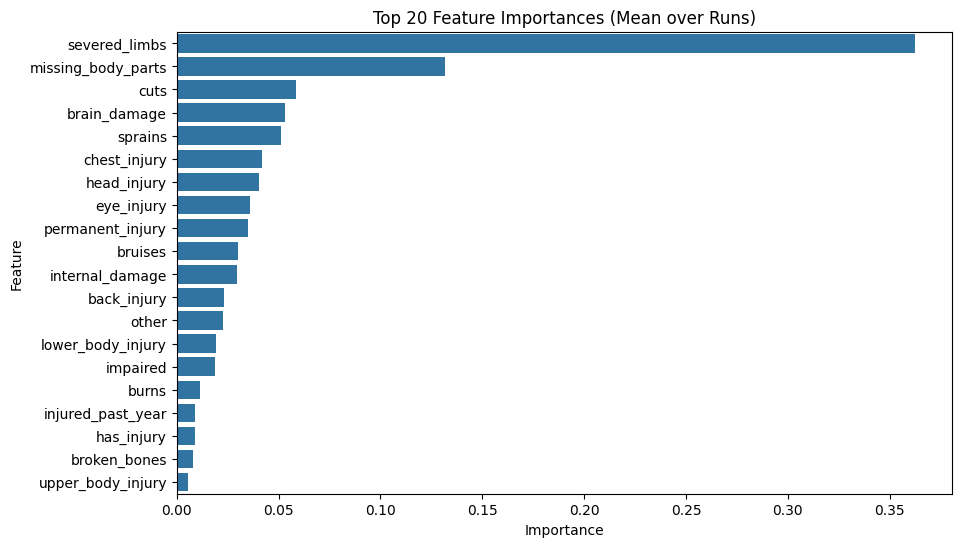

In [61]:
target_variable = "emotional_mental_health_disorder"
num_runs = 10 

correlations = []
feature_importances_list = []

for _ in range(num_runs):
    correlation = df.corr()[target_variable]
    correlations.append(correlation)
    feature_importances_list.append(rf_model.feature_importances_)

mean_correlation = pd.concat(correlations, axis=1).mean(axis=1).sort_values(ascending=False)


mean_feature_importance = np.mean(feature_importances_list, axis=0)

feature_importances = pd.DataFrame({
    "Feature": df.drop(columns=[target_variable]).columns,
    "Importance": mean_feature_importance
}).sort_values(by="Importance", ascending=False)

print("\nTop Important Features:\n", feature_importances.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances["Importance"][:20], y=feature_importances["Feature"][:20])
plt.title("Top 20 Feature Importances (Mean over Runs)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


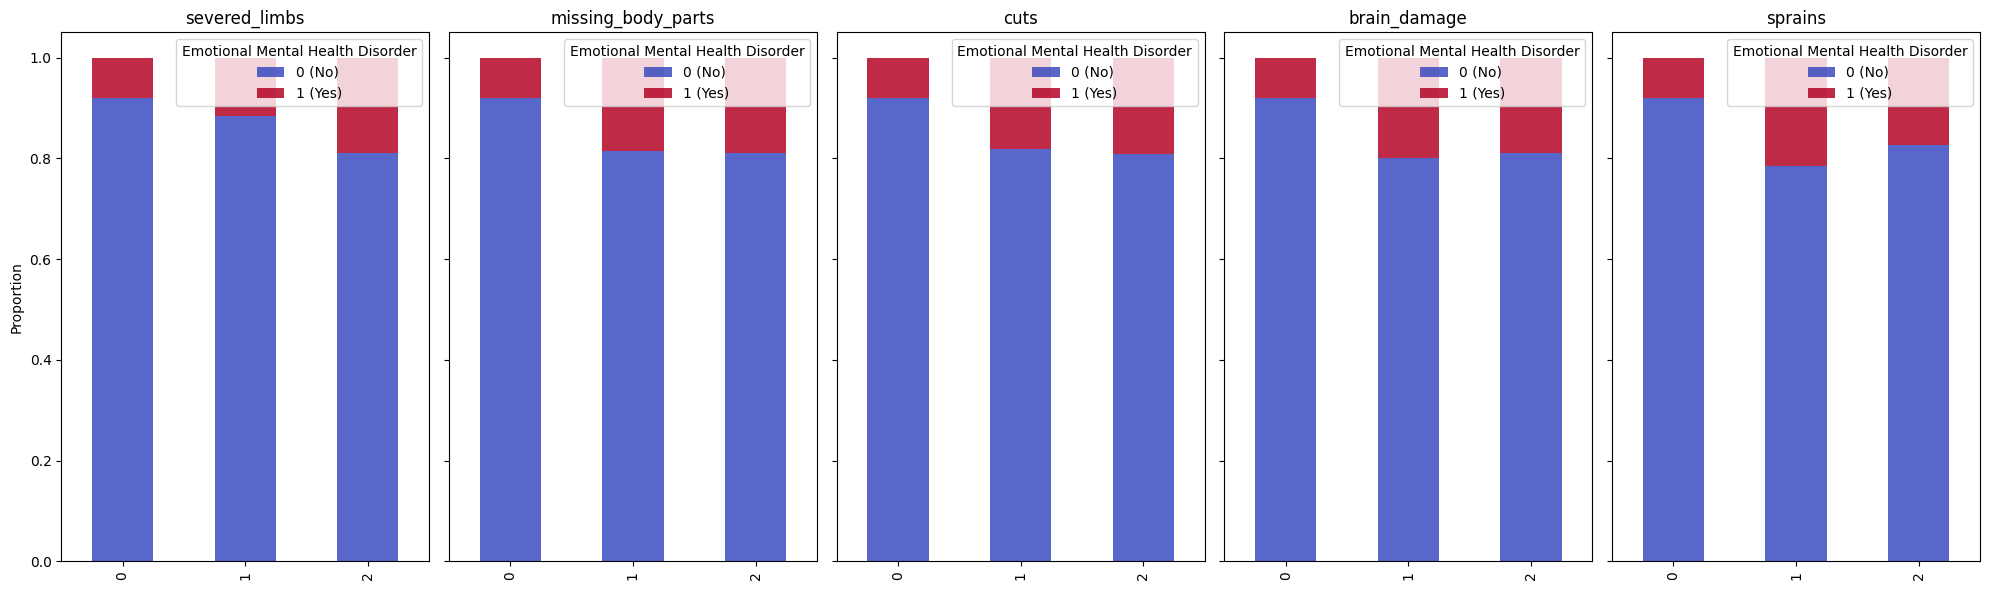

In [62]:

top_5_features = feature_importances.nlargest(5, "Importance")["Feature"]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), sharey=True)

for i, feature in enumerate(top_5_features):
    grouped_df = df.groupby(feature)[target_variable].value_counts(normalize=True).unstack()
    
    grouped_df.plot(kind='bar', stacked=True, ax=axes[i], colormap="coolwarm", alpha=0.85)
    
    axes[i].set_title(feature)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Proportion")
    axes[i].legend(title="Emotional Mental Health Disorder", labels=["0 (No)", "1 (Yes)"])

plt.tight_layout()
plt.show()

